## MHW Case Studies Figure – Figure 1 in Manuscript

In [13]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:38579' processes=7 threads=7, memory=256.00 GiB>

In [1]:
## LOAD IN OBSERVED AND MODELLED MHW STATISTICS
import xarray as xr
noaa_mhw_stats = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/mhws_NOAA.nc')
noaa_mhw_stats.load()
model_mhw_stats = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/full_MHW_data.nc')
model_mhw_stats.load()

<xarray.Dataset> Size: 475MB
Dimensions:          (lat: 171, lon: 1440, event: 24)
Coordinates:
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat              (lat) float64 1kB -81.08 -80.97 -80.87 ... -63.17 -63.06
  * event            (event) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    index_start      (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 2MB 0 0 0 0 0 0 0 0 0 ... 9 9 7 8 7 7 6 8
    index_peak       (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 47MB nan nan nan ... nan nan nan

In [8]:
## LOAD IN SEA-ICE DATA FROM ACCESS-OM2
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

## HAVE TO ASSIGN THE DAYS FROM THE SEA-ICE DATA TO THE CLIMATOLOGY
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

clim = ice_clim.sel(dayofyear=ice['dayofyear'])

clim_ice_access = ice_clim.aice.load()
ice_access = ice.aice.load()

In [9]:
##LOAD IN THE NOAA SEA-ICE DATA HERE 
import glob
import xarray as xr
import re

import xarray as xr

# Open only 2000–2023 files
sea_ice = xr.open_mfdataset(
    [
        f'/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/icec.day.mean.{year}.nc'
        for year in range(1982, 2024)
    ],
    combine='by_coords',
    chunks={'time': 365}  # chunk by year to reduce memory usage
)

# Select Antarctic region (latitudes south of -55)
sea_ice = sea_ice.sel(lat=slice(-90, -55))

ice_clim = xr.open_dataset('/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/ice_clim.nc')
ice_clim

# Assign dayofyear to c_ice
c_ice = sea_ice.assign_coords(dayofyear=sea_ice['time'].dt.dayofyear)

# Align climatology using dayofyear and assign dates from temp
climatology_ice = ice_clim.sel(dayofyear=c_ice['dayofyear'])
climatology_ice = climatology_ice.icec.assign_coords(time=c_ice['time'])

noaa_sea_ice = c_ice.icec
noaa_clim_sea_ice = climatology_ice

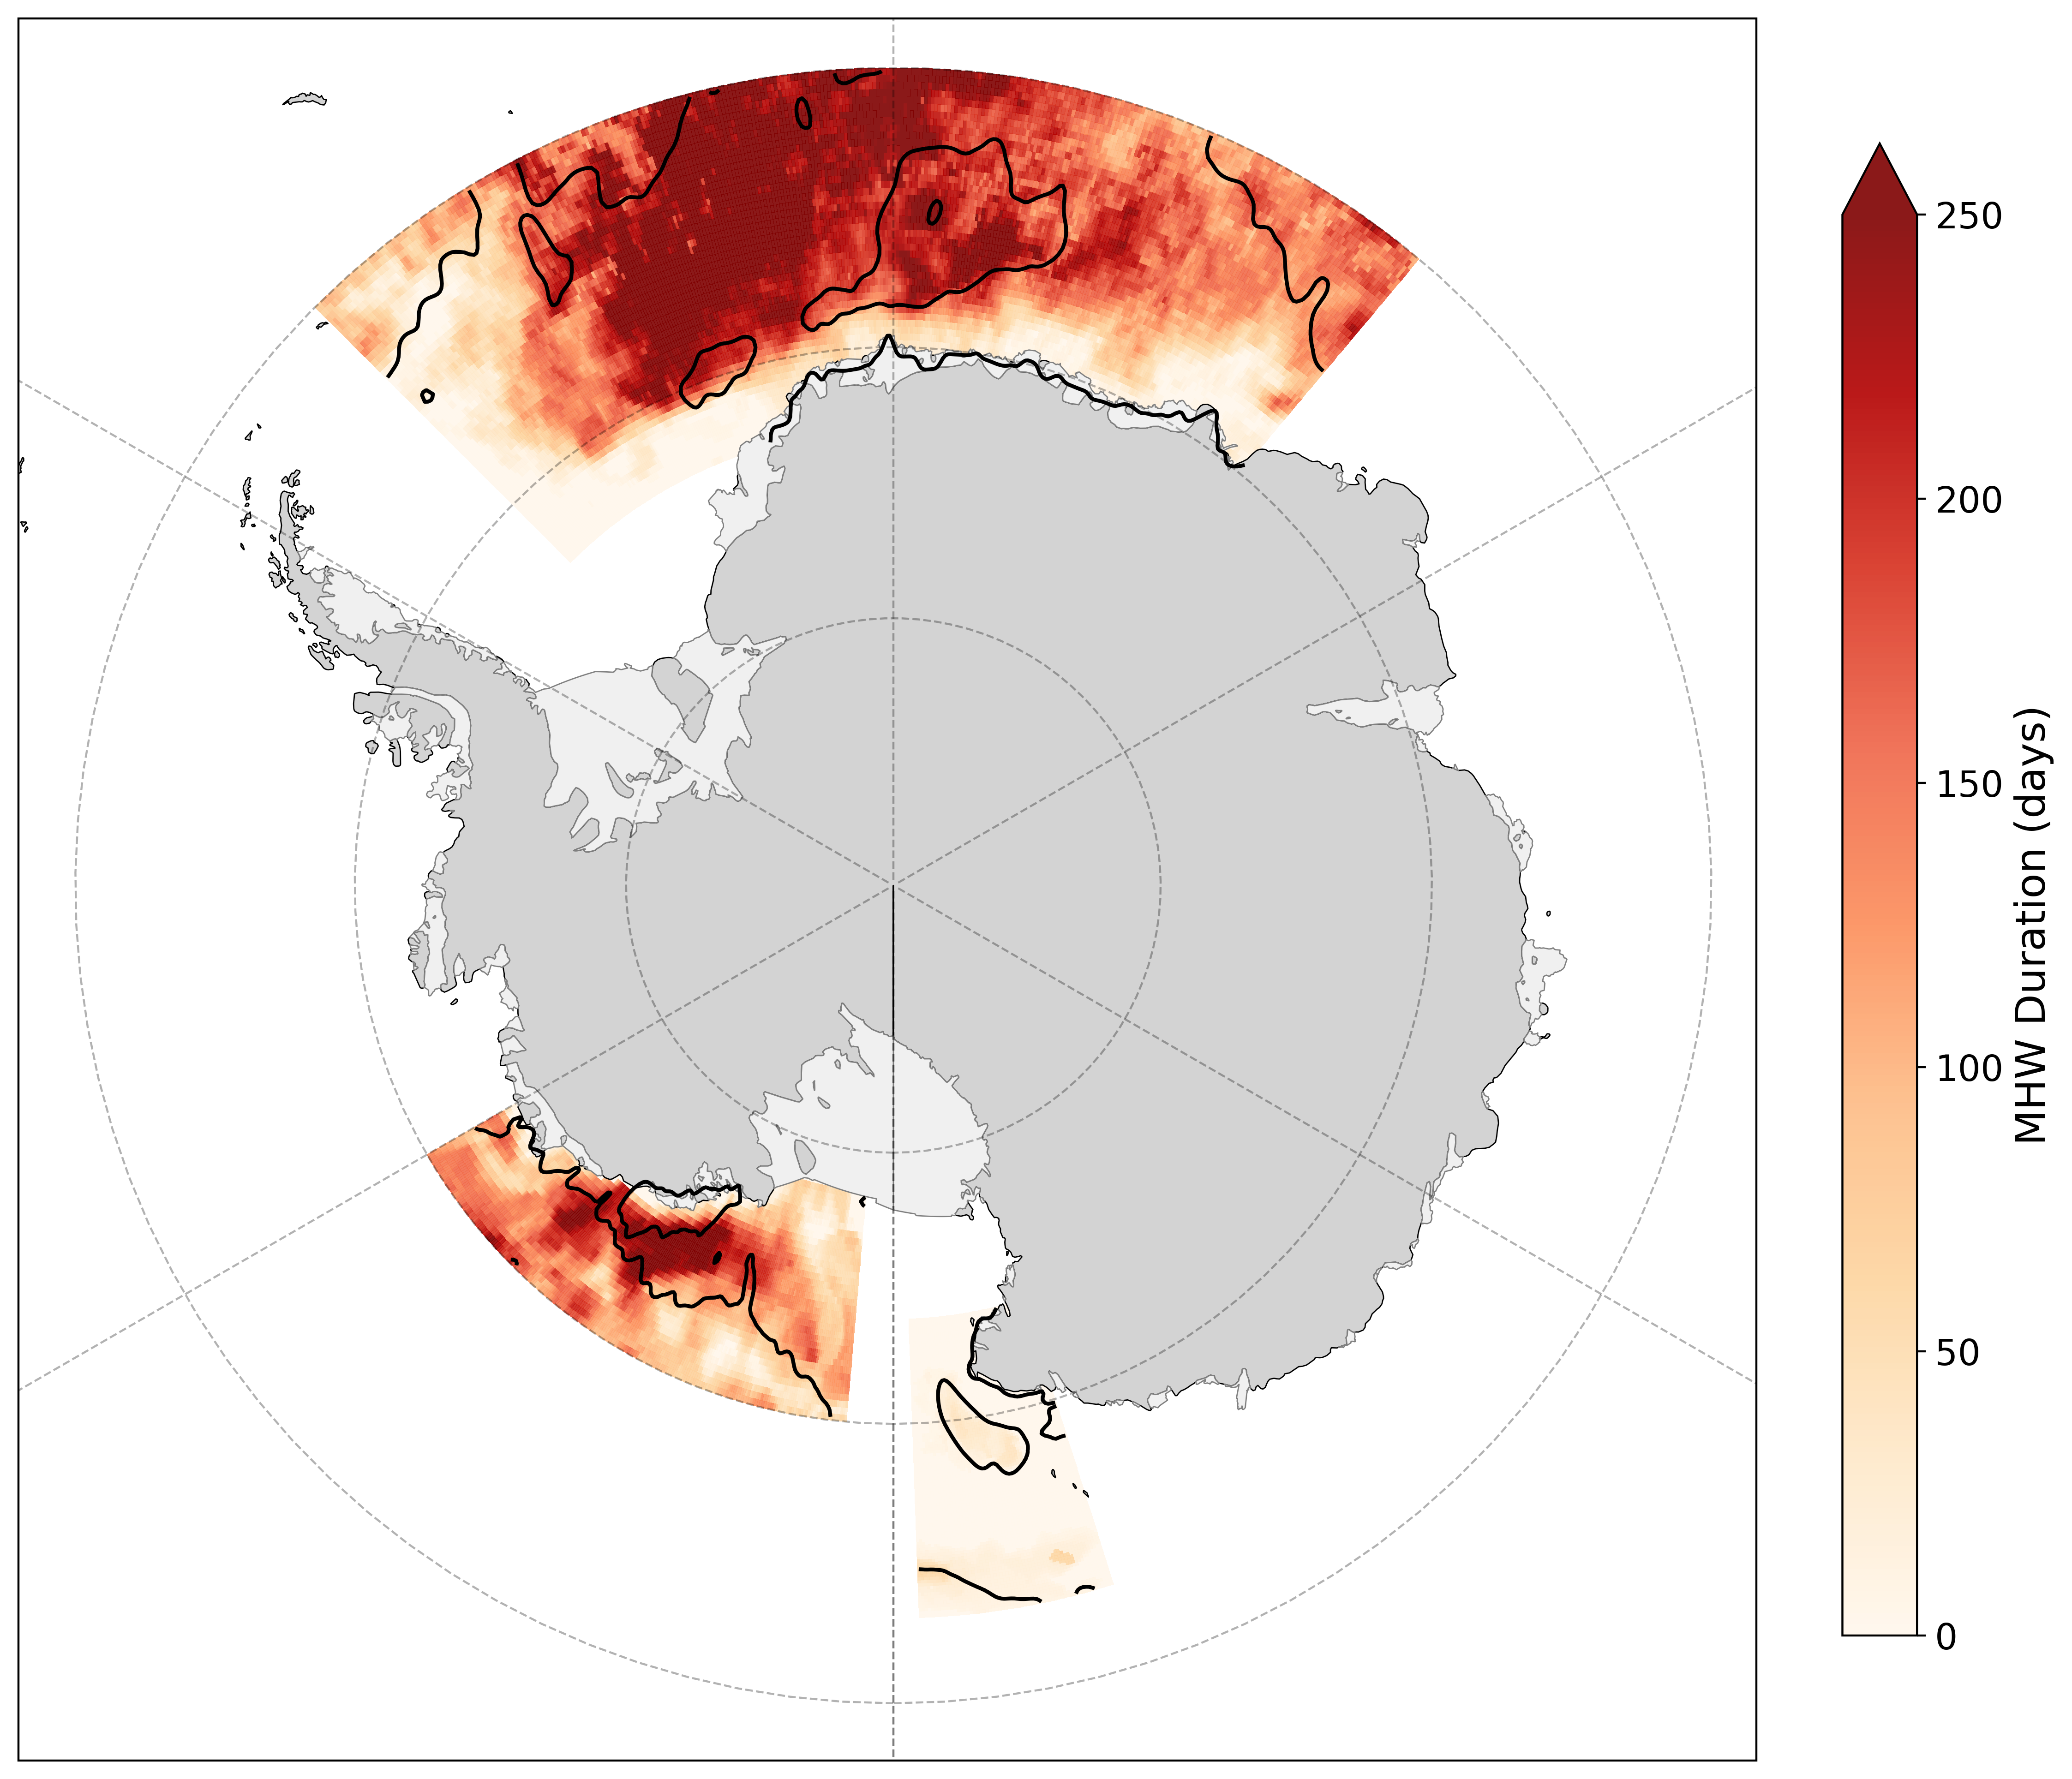

CPU times: user 25.4 s, sys: 2.62 s, total: 28.1 s
Wall time: 28.5 s


In [43]:
%%time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import gaussian_filter

## FIX THE COORDINATE SYSTEM OF THE DATA TO ENSURE IT IS UNIFORM FOR BOTH (NOAA GOES 0-360, ACCESS-OM2 GOES -280 TO 80)
def _to_lon180(ds, lon_name="lon"):
    if lon_name not in ds.coords:
        return ds
    lon = ds[lon_name]
    if float(lon.max()) > 180:
        lon180 = ((lon + 180) % 360) - 180
        ds = ds.assign_coords({lon_name: lon180})
        ds = ds.sortby(lon_name)
    return ds

## PICKING THE CASE STUDY MHW EVENTS THAT WE SELECTED IN THIS THESIS
def filter_event(ds, start, end, lon_bounds=None, lat_bounds=None):
    if ds is None:
        return ds
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    ds2 = _to_lon180(ds.copy(), lon_name="lon")
    if lon_bounds:
        ds2 = ds2.sel(lon=slice(*lon_bounds))
    if lat_bounds:
        ds2 = ds2.sel(lat=slice(*lat_bounds))
    if ds2.lon.size == 0 or ds2.lat.size == 0:
        return ds2.sel(event=[])
    date_start = ds2["date_start"].min(dim=("lat", "lon"), skipna=True)
    date_end = ds2["date_end"].max(dim=("lat", "lon"), skipna=True)
    mask = (date_start <= np.datetime64(end)) & (date_end >= np.datetime64(start))
    selected_events = ds2["event"][mask.values]
    return ds2.sel(event=selected_events) if selected_events.size > 0 else ds2.sel(event=[])

def safe_sum(da, dim):
    if da is None or dim not in da.dims or da.sizes.get(dim, 0) == 0:
        return None
    return da.sum(dim=dim, skipna=True)

def select_by_bounds(da, lon_min, lon_max, lat_min, lat_max, lon_name="lon", lat_name="lat"):
    if da is None:
        return da
    da = _to_lon180(da, lon_name=lon_name)
    return da.sel({lon_name: slice(lon_min, lon_max), lat_name: slice(lat_min, lat_max)})

## Filter model
start, end = np.datetime64("2020-04-01"), np.datetime64("2020-10-31")
model_mask = (model_mhw_stats["date_start"] <= end) & (model_mhw_stats["date_end"] >= start)
model_filtered = model_mhw_stats.where(model_mask, drop=True).sel(lon=slice(-200, -182), lat=slice(-76, -63))

## ACCESS ice coordinates
ice_lon_coord = "xt_ocean" if "xt_ocean" in ice_access.dims else "lon"
ice_lat_coord = "yt_ocean" if "yt_ocean" in ice_access.dims else "lat"
ice_access_filtered = ice_access.sel({
    ice_lon_coord: slice(-200, -182),
    ice_lat_coord: slice(-76, -63)
})

# Events and sea-ice dictionary
events = {
    "2021–22 (Nov–May)": filter_event(noaa_mhw_stats, "2021-11-01", "2022-06-30",
                                      lon_bounds=(-175, -120), lat_bounds=(-79, -70)),
    "2016–17 (Nov–May)": filter_event(noaa_mhw_stats, "2016-11-01", "2017-04-30",
                                      lon_bounds=(-45, 40), lat_bounds=(-73, -60)),
    "2020 (May–Oct)": model_filtered
}
sea_ice_dict = {
    "2021–22 (Nov–May)": noaa_sea_ice,
    "2016–17 (Nov–May)": noaa_sea_ice,
    "2020 (May–Oct)": ice_access_filtered
}
sea_ice_date_spec = {
    "2021–22 (Nov–May)": (2022, 1),
    "2016–17 (Nov–May)": (2016, 12),
    "2020 (May–Oct)": (2020, 9)
}

## MHW colour scale
all_vals = [
    np.ravel(da.values)
    for ds in events.values()
    if ds is not None and "duration" in ds
    and (da := safe_sum(ds["duration"], "event")) is not None
    and da.size > 0
]
vmin = np.nanmin(np.concatenate(all_vals)) if all_vals else 0
vmax = 250
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

## Plotting routine
fig = plt.figure(figsize=(15, 15), dpi=400)
proj = ccrs.SouthPolarStereo()
ax = plt.axes(projection=proj)

## Background, land and ice shelves
ax.add_feature(cfeature.LAND.with_scale("50m"), facecolor='lightgray', edgecolor="black", linewidth=0.5, zorder=2)
ax.set_facecolor('white')
ice_shelves = cfeature.NaturalEarthFeature(category='physical', name='antarctic_ice_shelves_polys', scale='50m')
ax.add_feature(ice_shelves, facecolor='#f0f0f0', edgecolor='gray', linewidth=0.5, zorder=2)

mappable = None
for title, ds_event in events.items():
    da = safe_sum(ds_event["duration"], "event")
    if da is None or da.size == 0:
        continue
    ds_tmp = _to_lon180(ds_event)
    
    # MHW duration
    mappable = da.plot(
        x="lon", y="lat", transform=ccrs.PlateCarree(),
        cmap="OrRd", norm=norm, add_colorbar=False, ax=ax, alpha=0.9,
        extend='max', zorder=1
    )

    # Sea-ice data
    si_data = sea_ice_dict.get(title)
    if si_data is not None:
        lon_coord = "xt_ocean" if "xt_ocean" in si_data.dims else "lon"
        lat_coord = "yt_ocean" if "yt_ocean" in si_data.dims else "lat"
        year, month = sea_ice_date_spec[title]
        si = select_by_bounds(si_data,
                              float(ds_tmp.lon.min()), float(ds_tmp.lon.max()),
                              float(ds_tmp.lat.min()), float(ds_tmp.lat.max()),
                              lon_name=lon_coord, lat_name=lat_coord)
        if 'time' in si.dims and si.sizes['time'] > 0:
            si_avg = si.sel(time=(si['time'].dt.year == year) & (si['time'].dt.month == month)).mean(dim="time", skipna=True)
            if np.isfinite(si_avg).any():
                smoothed_si = gaussian_filter(si_avg.fillna(0).values, sigma=1.5)
                si_avg = xr.DataArray(smoothed_si, dims=si_avg.dims, coords=si_avg.coords)
                contour_level = [0.85] if title == "2020 (May–Oct)" else [0.3]
                si_avg.plot.contour(
                    x=lon_coord, y=lat_coord, ax=ax, transform=ccrs.PlateCarree(),
                    levels=contour_level, colors=['black'], linewidths=1.5, zorder=3
                )


## Map and grid
ax.set_extent([-180, 180, -90, -58], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.8, color='black', alpha=0.3, linestyle='--')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
gl.ylocator = plt.FixedLocator(np.arange(-80, -50, 10))
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 12, 'color': 'black', 'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

## Colourbar
if mappable:
    cbar = plt.colorbar(mappable, ax=ax, orientation="vertical", pad=0.04, shrink=0.7, extend='max')
    cbar.set_label("MHW Duration (days)", fontsize=16)
    cbar.ax.tick_params(labelsize=14)

## Save figure
# plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/southern_ocean_mhw.png',
#             dpi=800, bbox_inches='tight', pad_inches=0.1)
# plt.show()


# MHW Model Validation – Figure 2 in Manuscript

In [4]:
import xarray as xr
noaa_mhw = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/mhws_NOAA.nc')
noaa_mhw.load()
access_mhw = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/full_MHW_data.nc')
access_mhw.load()

<xarray.Dataset> Size: 475MB
Dimensions:          (lat: 171, lon: 1440, event: 24)
Coordinates:
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat              (lat) float64 1kB -81.08 -80.97 -80.87 ... -63.17 -63.06
  * event            (event) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    index_start      (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 2MB 0 0 0 0 0 0 0 0 0 ... 9 9 7 8 7 7 6 8
    index_peak       (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 47MB nan nan nan ... nan nan nan

In [5]:
noaa_mhw = noaa_mhw.sel(lat = slice(-90,-63))

In [3]:
access_mhw

<xarray.Dataset> Size: 475MB
Dimensions:          (lat: 171, lon: 1440, event: 24)
Coordinates:
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat              (lat) float64 1kB -81.08 -80.97 -80.87 ... -63.17 -63.06
  * event            (event) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    index_start      (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 2MB 0 0 0 0 0 0 0 0 0 ... 9 9 7 8 7 7 6 8
    index_peak       (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 47MB nan nan nan ... nan nan nan

Total possible days in all seasons: 1210


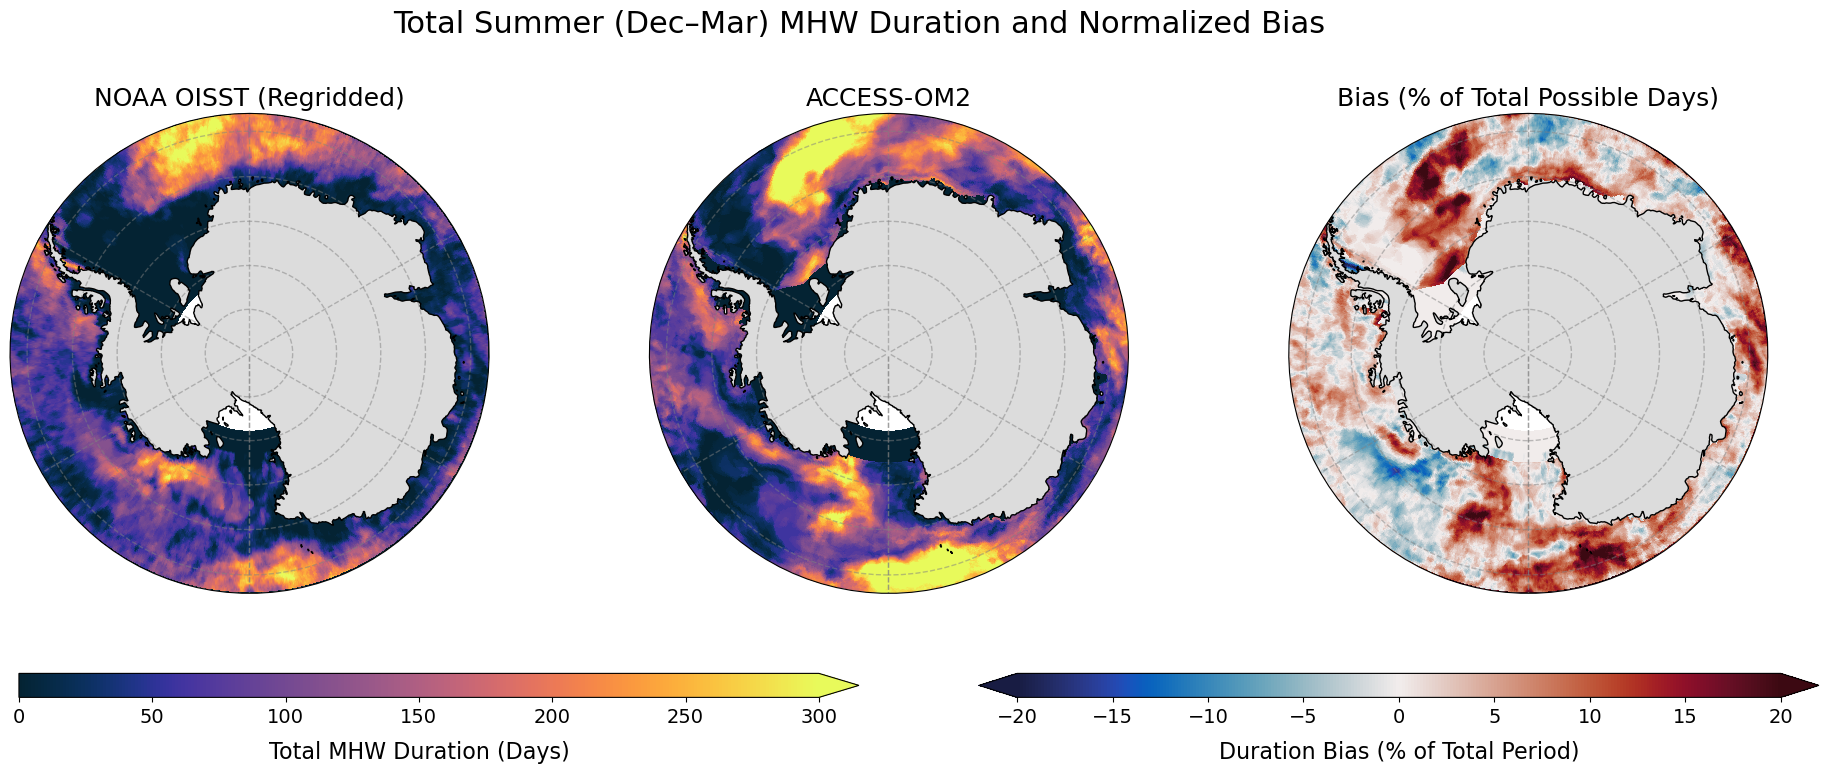

In [4]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import xarray as xr
import xesmf as xe
import os

# =============================================================================
# ASSUMPTION: You have loaded your data into these variables:
# noaa_mhw = xr.open_dataset(...)
# access_mhw = xr.open_dataset(...)
# Also assume they have 'date_start' and 'date_end' variables.
# =============================================================================

# --- 1. Function to Calculate Clipped Seasonal Duration ---

def calculate_clipped_duration(ds):
    """
    Calculates the total duration of MHWs that fall STRICTLY within the
    December-March summer season for each year.
    """
    if 'event' not in ds.dims or ds.sizes['event'] == 0:
        template = ds['duration'].isel(event=0, drop=True)
        return xr.zeros_like(template)

    start_year = int(ds.date_start.dt.year.min().item())
    end_year = int(ds.date_start.dt.year.max().item())

    seasonal_durations = []
    for year in range(start_year, end_year + 1):
        season_start = np.datetime64(f"{year}-11-01")
        season_end = np.datetime64(f"{year+1}-04-30")

        overlap_start = np.maximum(ds.date_start.values, season_start)
        overlap_end = np.minimum(ds.date_end.values, season_end)
        overlap_days = (overlap_end - overlap_start) / np.timedelta64(1, 'D') + 1
        clipped_days_per_event = np.maximum(0, overlap_days)

        seasonal_durations.append(
            xr.DataArray(clipped_days_per_event, coords=ds.duration.coords)
        )
    
    total_clipped_duration_per_event = sum(seasonal_durations)
    total_duration_map = total_clipped_duration_per_event.sum(dim="event")
    
    return total_duration_map


# --- 2. Calculate Durations, Regrid, and Calculate NEW Percentage Bias ---

## Calculate total MHW days for each dataset
dur1_summer_native = calculate_clipped_duration(noaa_mhw)
dur2_summer = calculate_clipped_duration(access_mhw)

## Regridding Step
weight_file = 'bilinear_noaa_to_access_weights.nc' 
regridder = xe.Regridder(dur1_summer_native, dur2_summer, "bilinear", filename=weight_file)
dur1_summer_regridded = regridder(dur1_summer_native)

## NEW: Calculate the total number of days in the sampling period
# We determine the years from the observation data
start_year = int(noaa_mhw.date_start.dt.year.min().item())
end_year = int(noaa_mhw.date_start.dt.year.max().item())
total_possible_days = 0
for year in range(start_year, end_year + 1):
    season_start = np.datetime64(f"{year}-11-01")
    season_end = np.datetime64(f"{year+1}-03-31")
    # Add the number of days in this season (inclusive)
    days_in_season = (season_end - season_start).astype('timedelta64[D]').astype(int) + 1
    total_possible_days += days_in_season

print(f"Total possible days in all seasons: {total_possible_days}")

## NEW: Calculate the bias as a percentage of total possible days
absolute_bias = dur2_summer - dur1_summer_regridded
bias_percent = (absolute_bias / total_possible_days) * 100
bias_percent.name = 'duration_bias_percent' 

# --- 3. Plotting Code with Percentage Bias Map ---

## Stylistic choices
plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14,
    'figure.titlesize': 20
})

## Create a 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
crs = ccrs.PlateCarree()
extent = [-180, 180, -90, -63]

## Define colorbar limits
vmax_duration = 300 
vmax_bias = 20      # ADJUSTED: Bias is now a percentage, so vmax will be smaller. 20% is a good starting point.

# The data and titles for all three plots
plots = [
    (dur1_summer_regridded, "NOAA OISST (Regridded)"),
    (dur2_summer, "ACCESS-OM2"),
    (bias_percent, "Bias (% of Total Possible Days)"), # UPDATED TITLE
]

## Plotting Loop
p_duration, p_bias = None, None 

for i, (ax, (data, title)) in enumerate(zip(axes, plots)):
    ax.set_extent(extent, crs)
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=2)
    ax.coastlines(zorder=3, linewidth=1.0)
    
    if i < 2: 
        p = data.plot.pcolormesh(
            ax=ax, transform=crs, cmap=cmocean.cm.thermal,
            vmax=vmax_duration, vmin=0, add_colorbar=False
        )
        p_duration = p
    else: 
        p = data.plot.pcolormesh(
            ax=ax, transform=crs, cmap=cmocean.cm.balance,
            vmax=vmax_bias, vmin=-vmax_bias, add_colorbar=False
        )
        p_bias = p

    ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = plt.matplotlib.path.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.set_title(title)

## Adjust figure layout and add two separate colorbars
fig.subplots_adjust(bottom=0.25, top=0.85, wspace=0.1)

cbar_ax1 = fig.add_axes([0.15, 0.12, 0.35, 0.03]) 
cbar1 = fig.colorbar(p_duration, cax=cbar_ax1, orientation='horizontal', extend='max')
cbar1.set_label('Total MHW Duration (Days)', labelpad=10)
cbar1.ax.tick_params(labelsize=14)

# Colorbar for Bias - UPDATED LABEL
cbar_ax2 = fig.add_axes([0.55, 0.12, 0.35, 0.03]) 
cbar2 = fig.colorbar(p_bias, cax=cbar_ax2, orientation='horizontal', extend='both')
cbar2.set_label('Duration Bias (% of Total Period)', labelpad=10)
cbar2.ax.tick_params(labelsize=14)

# UPDATED TITLE to reflect new season and bias metric
plt.suptitle("Total Summer (Dec–Mar) MHW Duration and Normalized Bias", fontsize=22)

plt.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/MHW_duration_comparison_winter_intensity.png", dpi=400, bbox_inches='tight')

plt.show()

## Winter MHWs with Ice Edge - Figure 11 from Manuscript 

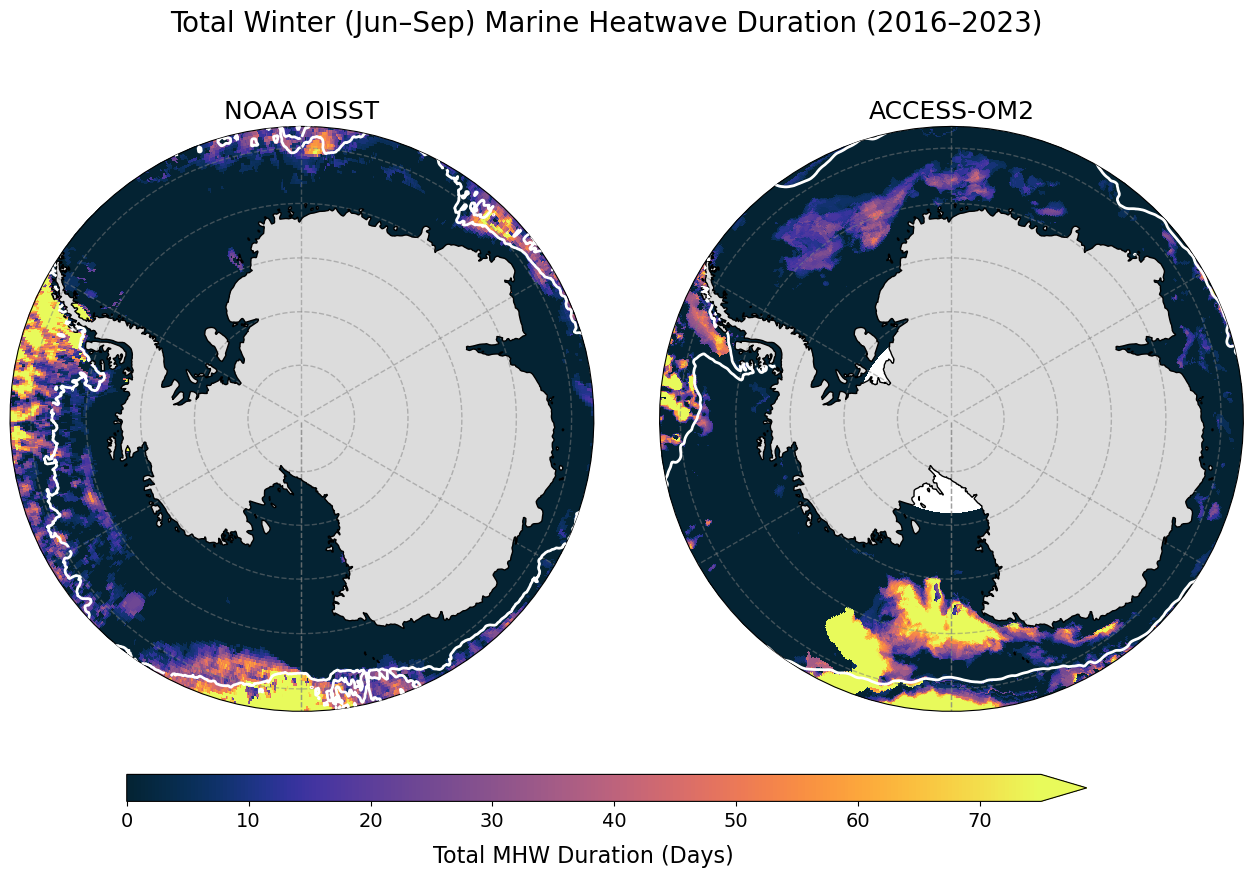

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean


ice = xr.open_mfdataset(
    ['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
     '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
     '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
     '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
     '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
     '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
     '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'],
    combine='by_coords'
)
ice_access = ice.aice.sel(time=slice('1982', '2023-12-29')).load()


# --- LOAD IN THE NOAA SEA-ICE DATA ---
# Open files from 1982 to 2023
sea_ice_noaa_raw = xr.open_mfdataset(
    [f'/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/icec.day.mean.{year}.nc'
     for year in range(1982, 2024)],
    combine='by_coords',
    chunks={'time': 365}
)
# Select Antarctic region and the 'icec' variable
noaa_sea_ice = sea_ice_noaa_raw.sel(lat=slice(-90, -55)).icec



## Define winter months for the Southern Hemisphere
winter_months = [6, 7, 8, 9]

sea_ice_months = [6]

def winter_duration(ds):
    """Calculates the total duration of MHWs during winter months."""
    months = ds["date_start"].dt.month
    mask = months.isin(winter_months)
    return ds["duration"].where(mask).sum(dim="event", skipna=True)

## Filter MHW datasets for total winter duration
dur1_winter = winter_duration(noaa_mhw)
dur2_winter = winter_duration(access_mhw)

## Prepare the sea-ice data for plotting
# Process NOAA sea ice
noaa_sea_ice_2022 = noaa_sea_ice.sel(time=noaa_sea_ice.time.dt.year == 2023)
noaa_ice_winter_avg = noaa_sea_ice_2022.sel(
    time=noaa_sea_ice_2022.time.dt.month.isin(sea_ice_months)
).mean(dim="time", skipna=True)

# Process ACCESS-OM2 sea ice
access_ice_2022 = ice_access.sel(time=ice_access.time.dt.year == 2023)
access_ice_winter_avg = access_ice_2022.sel(
    time=access_ice_2022.time.dt.month.isin(sea_ice_months)
).mean(dim="time", skipna=True)

## Plot

## Stylistic choices
plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14,
    'figure.titlesize': 20
})

## Create figures
fig, axes = plt.subplots(
    1, 2, figsize=(16, 9), subplot_kw={'projection': ccrs.SouthPolarStereo()}
)

## Map projection and extent
crs = ccrs.PlateCarree()
extent = [-180, 180, -90, -63]
vmax = 75

# Create a list of tuples, each containing the data for one subplot
plots = [
    (dur1_winter, "NOAA OISST", noaa_ice_winter_avg),
    (dur2_winter, "ACCESS-OM2", access_ice_winter_avg),
]

## Plotting Loop
for ax, (mhw_data, title, ice_data) in zip(axes, plots):
    ax.set_extent(extent, crs)
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=2)
    ax.coastlines(zorder=3, linewidth=1.0)
    
    # Plot MHW Duration Data
    p = mhw_data.plot.pcolormesh(
        ax=ax, transform=crs, cmap=cmocean.cm.thermal,
        vmax=vmax, vmin=0, add_colorbar=False, zorder=1
    )
    
    # Plot the corresponding sea-ice extent contour for 2022 winter average
    # The 15% level is a standard for defining the "sea-ice edge"
    if title == "ACCESS-OM2":
        # ACCESS model uses different coordinate names
        ice_data.plot.contour(
            ax=ax, transform=crs, levels=[0.4], colors='white', 
            linewidths=2.0, zorder=4, x='xt_ocean', y='yt_ocean'
        )
    else: # For NOAA OISST
        ice_data.plot.contour(
            ax=ax, transform=crs, levels=[0.4], colors='white', 
            linewidths=2.0, zorder=4
        )
    
    ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    # Set a circular boundary for the plot
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = plt.matplotlib.path.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.set_title(title)

# Adjust figure layout and add a shared colorbar
fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.set_label('Total MHW Duration (Days)', labelpad=10)
cbar.ax.tick_params(labelsize=14)

# Add a corrected super-title reflecting the winter months
plt.suptitle("Total Winter (Jun–Sep) Marine Heatwave Duration (2016–2023)", fontsize=20)

# Uncomment to save
plt.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/MHW_duration_winter_with_ice_edge_comparison.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import xarray as xr
import xesmf as xe
import os

# =============================================================================
# ASSUMPTION: You have loaded your data into these variables:
# noaa_mhw = xr.open_dataset(...)
# access_mhw = xr.open_dataset(...)
# =============================================================================

# --- 1. NEW: Calculate Mean Duration Per Summer Season ---

def mean_summer_duration(ds):
    """
    Calculates the total MHW duration for each summer season and then
    computes the mean across all seasons. A "summer season" is defined
    as October of year X to May of year X+1.
    """
    ## 'SUMMER' months
    summer_months = [10, 11, 12, 1, 2, 3, 4, 5]

    # 1. Filter for events that start within the defined summer months
    months = ds["date_start"].dt.month
    summer_events_mask = months.isin(summer_months)
    ds_summer = ds.where(summer_events_mask, drop=True)

    # 2. Assign a 'summer_year' coordinate to each event.
    # This is crucial for grouping. For example, an event in Feb 2017
    # belongs to the summer season that started in 2016.
    summer_year = xr.where(
        ds_summer.date_start.dt.month >= 10,
        ds_summer.date_start.dt.year,
        ds_summer.date_start.dt.year - 1
    )
    # Add this as a new coordinate to the dataset along the 'event' dimension
    ds_summer = ds_summer.assign_coords(summer_year=("event", summer_year.data))

    # 3. Group by this new 'summer_year', sum the duration of events within
    # each group, and then calculate the mean across all summer years.
    total_duration_per_summer = ds_summer.groupby("summer_year").sum(dim="event")["duration"]
    mean_duration = total_duration_per_summer.mean(dim="summer_year")
    
    return mean_duration

# --- 2. Calculate Durations, Regrid, and Calculate Bias ---

## Calculate mean summer duration for both datasets
dur1_mean_summer_native = mean_summer_duration(noaa_mhw)
dur2_mean_summer = mean_summer_duration(access_mhw)

## Regridding Step (Best Practice)
weight_file = 'bilinear_noaa_to_access_weights.nc' 
# Ensure the input grid for the regridder matches the data
regridder = xe.Regridder(dur1_mean_summer_native, dur2_mean_summer, "bilinear", filename=weight_file)
dur1_mean_summer_regridded = regridder(dur1_mean_summer_native)

## Calculate the bias based on the mean values
bias = dur2_mean_summer - dur1_mean_summer_regridded
bias.name = 'mean_duration_bias' # Give the DataArray a name

# --- 3. Plotting Code with Mean Bias Map ---

## Stylistic choices
plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14,
    'figure.titlesize': 20
})

## Create a 3-panel figure
fig, axes = plt.subplots(
    1, 3, 
    figsize=(24, 8),
    subplot_kw={'projection': ccrs.SouthPolarStereo()},
)

## Map projection and extent
crs = ccrs.PlateCarree()
extent = [-180, 180, -90, -63]

## Define colorbar limits - ADJUSTED for mean values (will be smaller than totals)
vmax_duration = 60  # Average days per summer
vmax_bias = 30      # Average bias per summer (symmetrical: -30 to 30)

# The data and titles for all three plots
plots = [
    (dur1_mean_summer_regridded, "NOAA OISST (Regridded)"),
    (dur2_mean_summer, "ACCESS-OM2"),
    (bias, "Bias (ACCESS-OM2 − NOAA)"),
]

## Plotting Loop
p_duration, p_bias = None, None # Placeholders for colorbar handles

for i, (ax, (data, title)) in enumerate(zip(axes, plots)):
    ax.set_extent(extent, crs)
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=2)
    ax.coastlines(zorder=3, linewidth=1.0)
    
    if i < 2: # For the first two (mean duration) plots
        p = data.plot.pcolormesh(
            ax=ax, transform=crs, cmap=cmocean.cm.thermal,
            vmax=vmax_duration, vmin=0, add_colorbar=False
        )
        p_duration = p # Store this handle for the first colorbar
    else: # For the third (bias) plot
        p = data.plot.pcolormesh(
            ax=ax, transform=crs, cmap=cmocean.cm.balance, # Diverging colormap
            vmax=vmax_bias, vmin=-vmax_bias, add_colorbar=False # Symmetrical limits
        )
        p_bias = p # Store this handle for the second colorbar

    ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = plt.matplotlib.path.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.set_title(title)

## Adjust figure layout and add two separate colorbars
fig.subplots_adjust(bottom=0.25, top=0.85, wspace=0.1)

# Colorbar for Duration
cbar_ax1 = fig.add_axes([0.15, 0.12, 0.35, 0.03]) 
cbar1 = fig.colorbar(p_duration, cax=cbar_ax1, orientation='horizontal', extend='max')
# UPDATED LABEL
cbar1.set_label('Mean Summer MHW Duration (Days/Year)', labelpad=10)
cbar1.ax.tick_params(labelsize=14)

# Colorbar for Bias
cbar_ax2 = fig.add_axes([0.55, 0.12, 0.35, 0.03]) 
cbar2 = fig.colorbar(p_bias, cax=cbar_ax2, orientation='horizontal', extend='both')
# UPDATED LABEL
cbar2.set_label('Mean Duration Bias (Days/Year)', labelpad=10)
cbar2.ax.tick_params(labelsize=14)

# UPDATED TITLE
plt.suptitle("Mean Summer (Oct–May) Marine Heatwave Duration (2016–2023) and Model Bias", fontsize=22)

# Uncomment the line below to save your figure
# plt.savefig("MHW_mean_duration_and_bias_comparison.png", dpi=400, bbox_inches='tight')

plt.show()

Calculating seasonal MHW durations...


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Calculating temporal correlation...


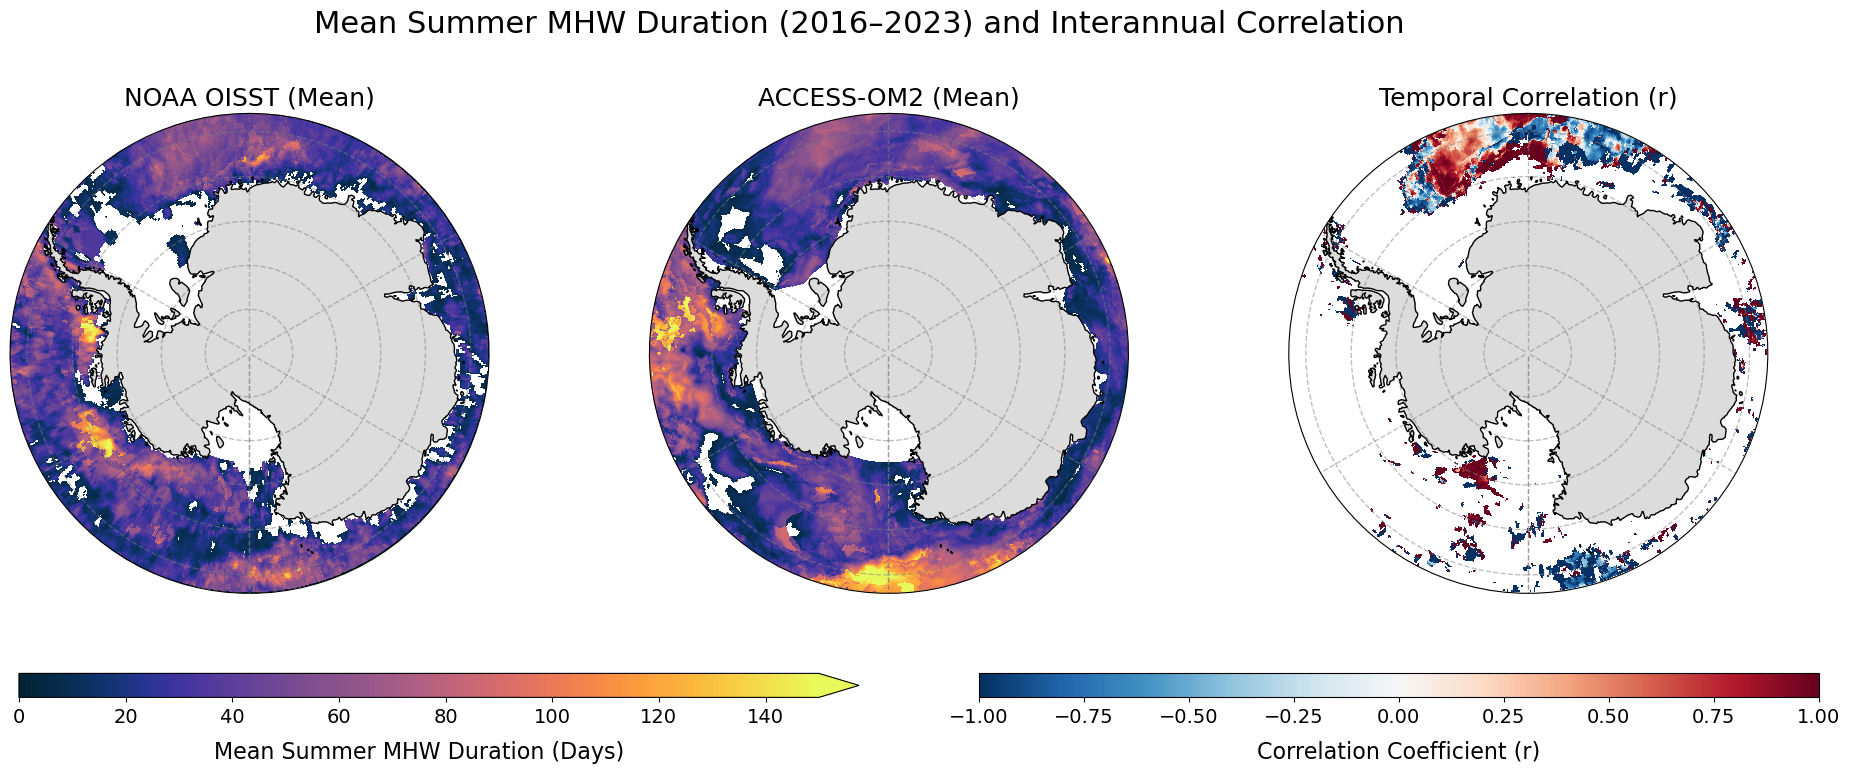

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import xarray as xr
import xesmf as xe
import os

# =============================================================================
# ASSUMPTION: You have loaded your data into these variables:
# noaa_mhw = xr.open_dataset(...)
# access_mhw = xr.open_dataset(...)
# =============================================================================

# --- 1. Create Seasonal Time Series ---

## 'SUMMER' months – primarily months where sea-ice concentration is low
summer_months = [10, 11, 12, 1, 2, 3, 4, 5]

def seasonal_summer_duration(ds):
    """
    Calculates the total MHW duration for each summer season.
    A season starting in Oct 2016 is labeled as season '2016'.
    """
    # CORRECTED FILTERING STEP: Use .where() with drop=True for conditional selection
    summer_event_mask = ds["date_start"].dt.month.isin(summer_months)
    ds_summer = ds.where(summer_event_mask, drop=True)
    
    # Determine the 'season' year for each event
    # If month is Oct-Dec, season year is the event's year.
    # If month is Jan-May, season year is the event's year - 1.
    season_year = xr.where(
        ds_summer['date_start'].dt.month >= 10,
        ds_summer['date_start'].dt.year,
        ds_summer['date_start'].dt.year - 1
    )
    
    # Group by this new 'season_year' and sum the durations
    seasonal_duration = ds_summer['duration'].groupby(season_year).sum(dim='event')
    seasonal_duration = seasonal_duration.rename({'group': 'season'}) # Rename the dimension
    return seasonal_duration

print("Calculating seasonal MHW durations...")
noaa_seasonal_native = seasonal_summer_duration(noaa_mhw)
access_seasonal = seasonal_summer_duration(access_mhw)


# --- 2. Regrid and Calculate Correlation ---

## Regridding Step (Best Practice)
weight_file = 'bilinear_noaa_to_access_weights.nc' 
regridder = xe.Regridder(noaa_seasonal_native, access_seasonal, "bilinear", filename=weight_file)
noaa_seasonal_regridded = regridder(noaa_seasonal_native)

## Calculate the temporal correlation along the 'season' dimension
print("Calculating temporal correlation...")
correlation_map = xr.corr(noaa_seasonal_regridded, access_seasonal, dim='season')
correlation_map.name = 'correlation'


# --- 3. Plotting Code with Correlation Map (No changes needed below) ---

plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14,
    'figure.titlesize': 20
})

fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

crs = ccrs.PlateCarree()
extent = [-180, 180, -90, -63]
vmax_duration = 150 

plots = [
    (noaa_seasonal_regridded.mean(dim='season'), "NOAA OISST (Mean)"),
    (access_seasonal.mean(dim='season'), "ACCESS-OM2 (Mean)"),
    (correlation_map, "Temporal Correlation (r)"),
]

p_duration, p_corr = None, None

for i, (ax, (data, title)) in enumerate(zip(axes, plots)):
    ax.set_extent(extent, crs)
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=2)
    ax.coastlines(zorder=3, linewidth=1.0)
    
    if i < 2:
        p = data.plot.pcolormesh(
            ax=ax, transform=crs, cmap=cmocean.cm.thermal,
            vmax=vmax_duration, vmin=0, add_colorbar=False
        )
        p_duration = p
    else:
        p = data.plot.pcolormesh(
            ax=ax, transform=crs, cmap='RdBu_r',
            vmax=1.0, vmin=-1.0, add_colorbar=False
        )
        p_corr = p

    ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = plt.matplotlib.path.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_title(title)

fig.subplots_adjust(bottom=0.25, top=0.85, wspace=0.1)

cbar_ax1 = fig.add_axes([0.15, 0.12, 0.35, 0.03]) 
cbar1 = fig.colorbar(p_duration, cax=cbar_ax1, orientation='horizontal', extend='max')
cbar1.set_label('Mean Summer MHW Duration (Days)', labelpad=10)
cbar1.ax.tick_params(labelsize=14)

cbar_ax2 = fig.add_axes([0.55, 0.12, 0.35, 0.03]) 
cbar2 = fig.colorbar(p_corr, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Correlation Coefficient (r)', labelpad=10)
cbar2.ax.tick_params(labelsize=14)

plt.suptitle("Mean Summer MHW Duration (2016–2023) and Interannual Correlation", fontsize=22)

plt.show()

## Example MHW Trends in the Ross

In [5]:
import xarray as xr
noaa_mhw = xr.open_dataset('/scratch/e14/ts7341/SEANOE/MHW_Statistics_Mask/full_MHW_data_1982_2024_RS_NOAA.nc')
noaa_mhw.load()
access_mhw = xr.open_dataset('/scratch/e14/ts7341/SEANOE/MHW_Statistics_Mask/full_MHW_data_1982_2024_RS.nc')
access_mhw.load()

<xarray.Dataset> Size: 85MB
Dimensions:          (lat: 66, lon: 320, event: 50)
Coordinates:
  * lon              (lon) float64 3kB -209.9 -209.6 -209.4 ... -130.4 -130.1
  * lat              (lat) float64 528B -76.96 -76.85 -76.75 ... -70.2 -70.09
  * event            (event) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    index_start      (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 8MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 8MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 169kB 0 0 0 0 0 0 0 ... 16 15 15 15 15 15
    index_peak       (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 8MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 8MB nan nan nan ... nan nan nan

In [15]:
print(noaa_mhw)
print(access_mhw)

<xarray.Dataset> Size: 141MB
Dimensions:          (lat: 24, lon: 320, event: 229)
Coordinates:
  * lat              (lat) float32 96B -76.88 -76.62 -76.38 ... -71.38 -71.12
  * lon              (lon) float32 1kB 150.1 150.4 150.6 ... 229.4 229.6 229.9
  * event            (event) int64 2kB 0 1 2 3 4 5 6 ... 223 224 225 226 227 228
Data variables:
    index_start      (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 14MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 14MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 61kB 0 0 0 0 0 0 0 ... 89 85 78 73 74 77
    index_peak       (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 14MB NaT NaT ... NaT NaT
    intensity_m

Preprocessing NOAA MHW data...
Preprocessing ACCESS MHW data...

Calculating trends for NOAA OISST...
  - Processing 5643 spatial points with MHW events.
  - Calculating linear trends...

Calculating trends for ACCESS-OM2...
  - Processing 15828 spatial points with MHW events.
  - Calculating linear trends...

Plotting results...


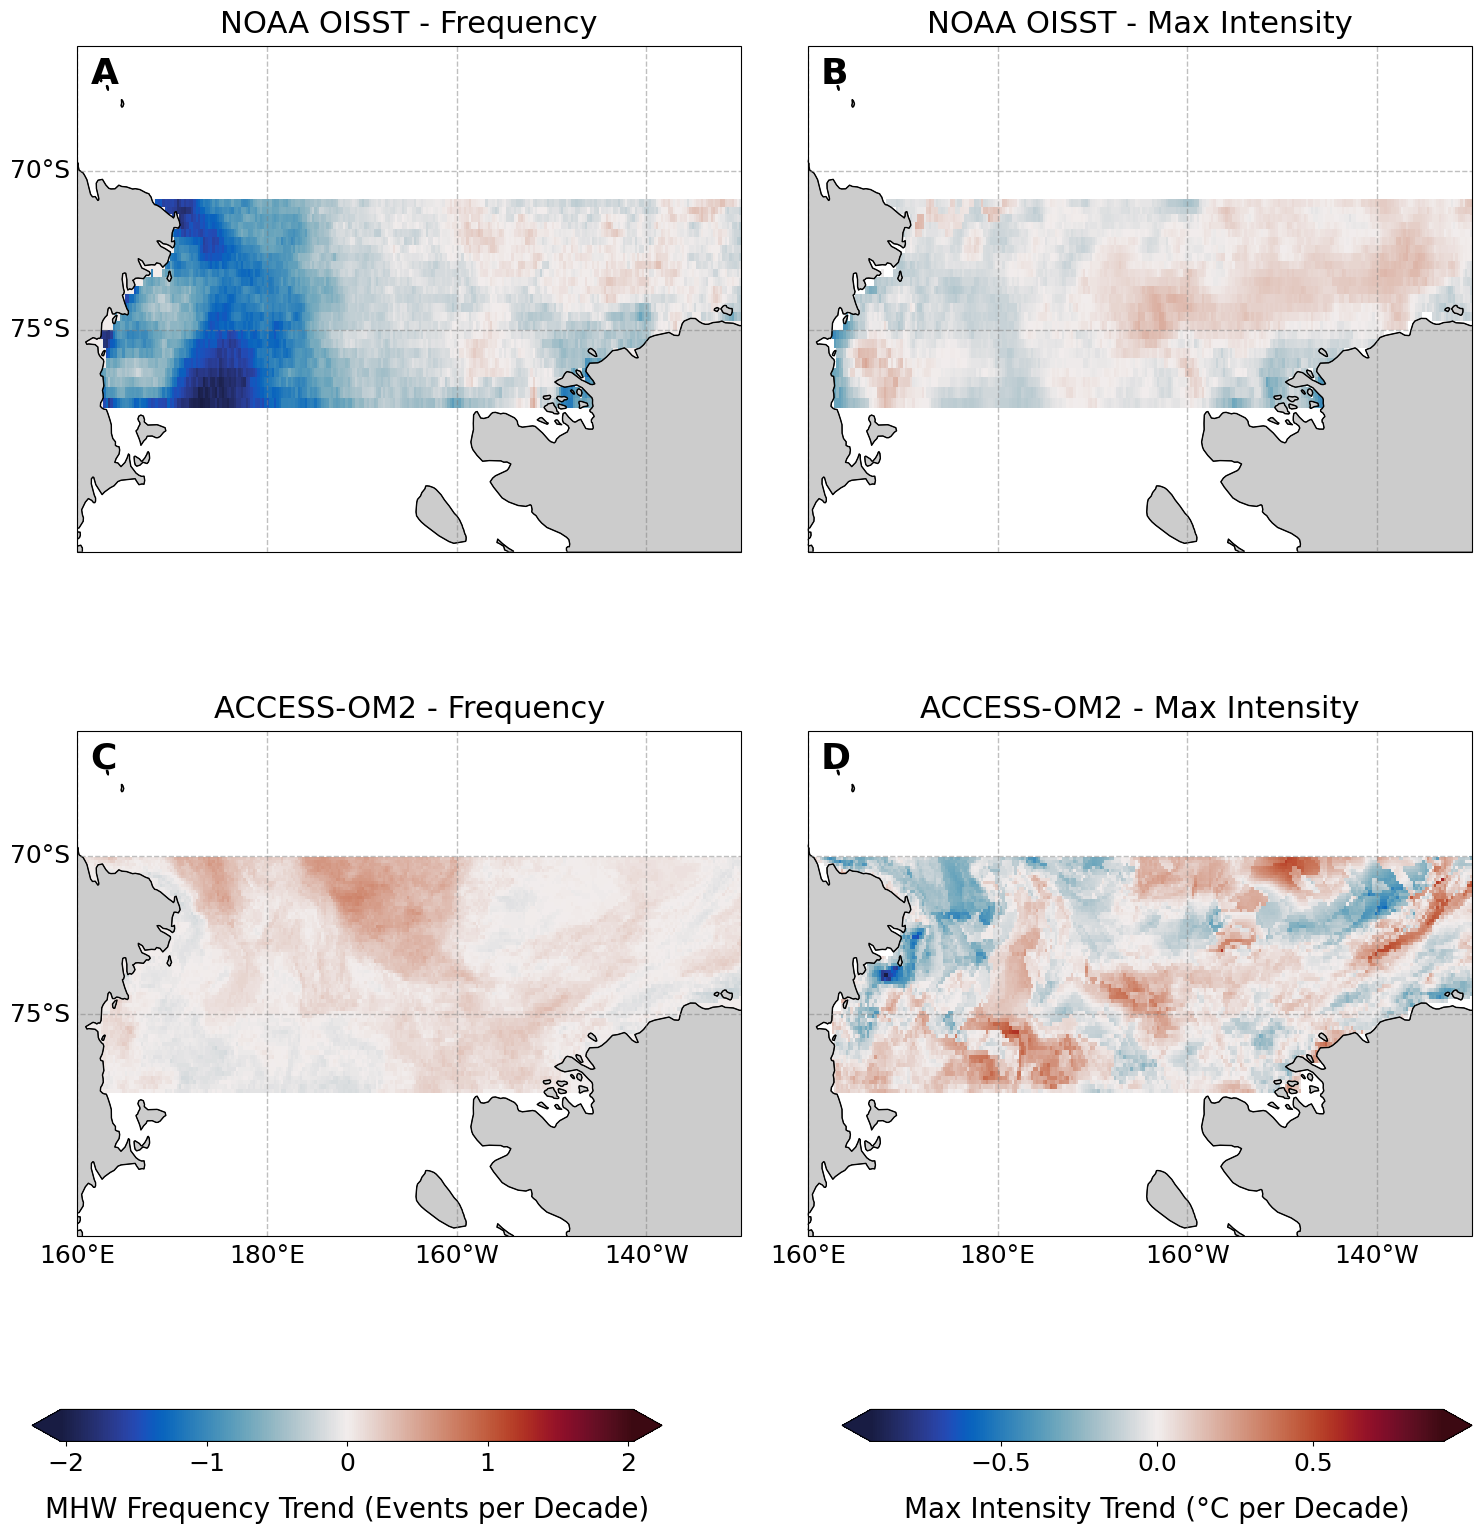

In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean


def preprocess_mhw_data(ds):
    """
    Standardizes longitude to -180 to 180 and sorts coordinates. This is 
    particularly important here because of the annoying wrapping around 
    issue at the 180 line in the Ross Sea.
    """
    # Convert longitude from any range (e.g., 0-360) to -180 to 180
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    
    ds = ds.sortby('lon')
    ds = ds.sortby('lat')
    return ds

noaa_mhw = preprocess_mhw_data(noaa_mhw)
access_mhw = preprocess_mhw_data(access_mhw)

# Calculating trends

def calculate_mhw_trends(mhw_ds):
    """
    Calculates decadal trends for MHW frequency and max intensity.
    """
    # Stack spatial dimensions
    stacked = mhw_ds.stack(space=('lat', 'lon'))

    # Pre-filter to remove spatial points with NO events
    valid_space_mask = stacked.date_start.notnull().any(dim='event')
    stacked_with_events_only = stacked.sel(space=valid_space_mask)

    # Drop empty event slots to make the dataset tidy
    valid_events = stacked_with_events_only.dropna(dim='event', how='all', subset=['date_start'])
    print(f"  - Processing {valid_events.space.size} spatial points with MHW events.")

    # Add a 'year' variable for easier grouping
    valid_events['year'] = valid_events.date_start.dt.year

    # --- Frequency Calculation ---
    def count_events_by_year(ds_group):
        group_simplified = ds_group.reset_index('space')
        return group_simplified.date_start.groupby(group_simplified.year).count()

    annual_frequency_stacked = valid_events.groupby('space', squeeze=False).apply(count_events_by_year)
    annual_frequency = annual_frequency_stacked.unstack('space').fillna(0)

    # --- Intensity Calculation ---
    def max_intensity_by_year(ds_group):
        group_simplified = ds_group.reset_index('space')
        return group_simplified.intensity_max.groupby(group_simplified.year).max()
        
    annual_max_intensity_stacked = valid_events.groupby('space', squeeze=False).apply(max_intensity_by_year)
    annual_max_intensity = annual_max_intensity_stacked.unstack('space')

    # Reindex to full time and space grid
    all_years = np.arange(int(mhw_ds.date_start.dt.year.min(skipna=True)), int(mhw_ds.date_start.dt.year.max(skipna=True)) + 1)
    annual_frequency = annual_frequency.reindex(year=all_years, lat=mhw_ds.lat, lon=mhw_ds.lon, fill_value=0)
    annual_max_intensity = annual_max_intensity.reindex(year=all_years, lat=mhw_ds.lat, lon=mhw_ds.lon, fill_value=np.nan)

    # --- Trend Calculation ---
    print("  - Calculating linear trends...")
    freq_coeffs = annual_frequency.polyfit(dim='year', deg=1, skipna=True)
    freq_trend = freq_coeffs.polyfit_coefficients.sel(degree=1) * 10 

    intensity_coeffs = annual_max_intensity.polyfit(dim='year', deg=1, skipna=True)
    intensity_trend = intensity_coeffs.polyfit_coefficients.sel(degree=1) * 10
    
    return freq_trend, intensity_trend

# Calculate trends for both datasets
print("\nCalculating trends for NOAA OISST...")
noaa_freq_trend_per_decade, noaa_intensity_trend_per_decade = calculate_mhw_trends(noaa_mhw)

print("\nCalculating trends for ACCESS-OM2...")
access_freq_trend_per_decade, access_intensity_trend_per_decade = calculate_mhw_trends(access_mhw)
# ======================================================================

# ======================================================================
# --- 4. Plotting ---
print("\nPlotting results...")

# Plotting Parameters
extent = [-200, -130, -80, -65] 
grid_label_size = 18; panel_title_size = 22; colorbar_label_size = 20
vmax_freq = max(abs(noaa_freq_trend_per_decade).max(), abs(access_freq_trend_per_decade).max())
vmax_intensity = max(abs(noaa_intensity_trend_per_decade).max(), abs(access_intensity_trend_per_decade).max())

plt.rcParams.update({'font.size': 14, 'axes.titlesize': panel_title_size, 'axes.labelsize': 16, 'xtick.labelsize': grid_label_size, 'ytick.labelsize': grid_label_size, 'legend.fontsize': 14})

fig, axes = plt.subplots(2, 2, figsize=(18, 16), subplot_kw={'projection': ccrs.Mercator(central_longitude=-180)})
axes = axes.flatten()

plots_data = [
    (noaa_freq_trend_per_decade, "NOAA OISST - Frequency", "Events per Decade", vmax_freq, 'A'),
    (noaa_intensity_trend_per_decade, "NOAA OISST - Max Intensity", "°C per Decade", vmax_intensity, 'B'),
    (access_freq_trend_per_decade, "ACCESS-OM2 - Frequency", "Events per Decade", vmax_freq, 'C'),
    (access_intensity_trend_per_decade, "ACCESS-OM2 - Max Intensity", "°C per Decade", vmax_intensity, 'D'),
]
plot_handles = []

for i, ax in enumerate(axes):
    data, title, cbar_label, vmax, label = plots_data[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    p = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-vmax, vmax=vmax, add_colorbar=False)
    plot_handles.append(p)
    
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=panel_title_size + 4, weight='bold', va='top')
    ax.set_title(title, fontsize=panel_title_size, pad=10)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=1)
    gl.xlocator = mticker.FixedLocator([160, 180, -160, -140]); gl.ylocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.top_labels = False; gl.right_labels = False
    gl.left_labels = (i % 2 == 0); gl.bottom_labels = (i >= 2)
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': grid_label_size}; gl.ylabel_style = {'size': grid_label_size}

fig.subplots_adjust(bottom=0.15, top=0.95, wspace=0.1, hspace=0.15)

cbar_ax_freq = fig.add_axes([0.1, 0.05, 0.35, 0.02]) 
cbar_freq = fig.colorbar(plot_handles[0], cax=cbar_ax_freq, orientation='horizontal', extend='both')
cbar_freq.set_label('MHW Frequency Trend (Events per Decade)', fontsize=colorbar_label_size, labelpad=15)
cbar_freq.ax.tick_params(labelsize=grid_label_size)

cbar_ax_int = fig.add_axes([0.55, 0.05, 0.35, 0.02]) 
cbar_int = fig.colorbar(plot_handles[1], cax=cbar_ax_int, orientation='horizontal', extend='both')
cbar_int.set_label('Max Intensity Trend (°C per Decade)', fontsize=colorbar_label_size, labelpad=15)
cbar_int.ax.tick_params(labelsize=grid_label_size)

# plt.savefig("MHW_Trend_Comparison_Stats.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def preprocess_mhw_data(ds):
    """
    Standardizes longitude to -180 to 180 and sorts coordinates.
    """
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby('lon').sortby('lat')
    return ds

print("Preprocessing NOAA MHW data...")
noaa_mhw = preprocess_mhw_data(noaa_mhw)
print("Preprocessing ACCESS MHW data...")
access_mhw = preprocess_mhw_data(access_mhw)

# Calculate Maximum Intensity Trend
def calculate_max_intensity_trend(mhw_ds):
    """
    Calculates the decadal trend for MHW max intensity.
    """
    # Stack spatial dimensions
    stacked = mhw_ds.stack(space=('lat', 'lon'))
    valid_space_mask = stacked.date_start.notnull().any(dim='event')
    stacked_with_events_only = stacked.sel(space=valid_space_mask)
    valid_events = stacked_with_events_only.dropna(dim='event', how='all', subset=['date_start'])
    print(f"  - Processing {valid_events.space.size} spatial points with MHW events.")

    valid_events['year'] = valid_events.date_start.dt.year

    # --- Max Intensity Calculation ---
    def max_intensity_by_year(ds_group):
        group_simplified = ds_group.reset_index('space')
        return group_simplified.intensity_max.groupby(group_simplified.year).max()
        
    annual_max_intensity_stacked = valid_events.groupby('space', squeeze=False).apply(max_intensity_by_year)
    annual_max_intensity = annual_max_intensity_stacked.unstack('space')

    # Reindex to full time and space grid
    all_years = np.arange(int(mhw_ds.date_start.dt.year.min(skipna=True)), int(mhw_ds.date_start.dt.year.max(skipna=True)) + 1)
    annual_max_intensity = annual_max_intensity.reindex(year=all_years, lat=mhw_ds.lat, lon=mhw_ds.lon, fill_value=np.nan)

    # --- Trend Calculation ---
    print("  - Calculating linear trend for max intensity...")
    max_intensity_coeffs = annual_max_intensity.polyfit(dim='year', deg=1, skipna=True)
    max_intensity_trend = max_intensity_coeffs.polyfit_coefficients.sel(degree=1) * 10
    
    return max_intensity_trend

# Calculate trends for both datasets
print("\nCalculating max intensity trend for NOAA OISST...")
noaa_max_intensity_trend = calculate_max_intensity_trend(noaa_mhw)

print("\nCalculating max intensity trend for ACCESS-OM2...")
access_max_intensity_trend = calculate_max_intensity_trend(access_mhw)

# Plot
print("\nPlotting results...")

# Plotting Parameters
extent = [-200, -130, -80, -65] 
grid_label_size = 20; panel_title_size = 24; colorbar_label_size = 22

# Determine a single, shared color scale for both plots
vmax = np.nanmax([abs(noaa_max_intensity_trend).max(), abs(access_max_intensity_trend).max()])

plt.rcParams.update({'font.size': 16, 'axes.titlesize': panel_title_size, 'axes.labelsize': 18, 'xtick.labelsize': grid_label_size, 'ytick.labelsize': grid_label_size})

# Create a 1x2 figure
fig, axes = plt.subplots(
    1, 2, 
    figsize=(20, 10), 
    subplot_kw={'projection': ccrs.Mercator(central_longitude=-180)}
)
axes = axes.flatten()

# Plot data for the two panels
plots_data = [
    (noaa_max_intensity_trend, "NOAA OISST", 'a'),
    (access_max_intensity_trend, "ACCESS-OM2", 'b'),
]

for i, ax in enumerate(axes):
    data, title, label = plots_data[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    # All plots use the same shared color scale (vmax)
    p = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-vmax, vmax=vmax, add_colorbar=False)
    
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=panel_title_size + 4, weight='bold', va='top')
    ax.set_title(title, fontsize=panel_title_size, pad=10)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=1)
    gl.xlocator = mticker.FixedLocator([160, 180, -160, -140]); gl.ylocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.top_labels = False; gl.right_labels = False
    
    # Update label logic for 1x2 grid
    gl.left_labels = (i == 0) # Only the first plot
    gl.bottom_labels = True   # Both plots are on the bottom row
    
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': grid_label_size}; gl.ylabel_style = {'size': grid_label_size}

# --- Shared Colorbar for ALL panels ---
fig.subplots_adjust(bottom=0.2, top=0.9, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03]) 
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('MHW Max Intensity Trend (°C per Decade)', fontsize=colorbar_label_size, labelpad=15)
cbar.ax.tick_params(labelsize=grid_label_size)

# Add a main title for the whole figure
start_year = int(noaa_mhw.date_start.dt.year.min())
end_year = int(noaa_mhw.date_start.dt.year.max())
fig.suptitle(f"Marine Heatwave Maximum Intensity Trends ({start_year}–{end_year})", fontsize=30, y=0.98)

plt.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/MHW_Max_Intensity_Trend_Comparison.png", dpi=400, bbox_inches='tight')
plt.show()